# MNIST DATALOADER

In [1]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import cupy as cp # linear algebra
import numpy as np
import struct
from array import array
from os.path  import join
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        

# SHOWING THE DATASET

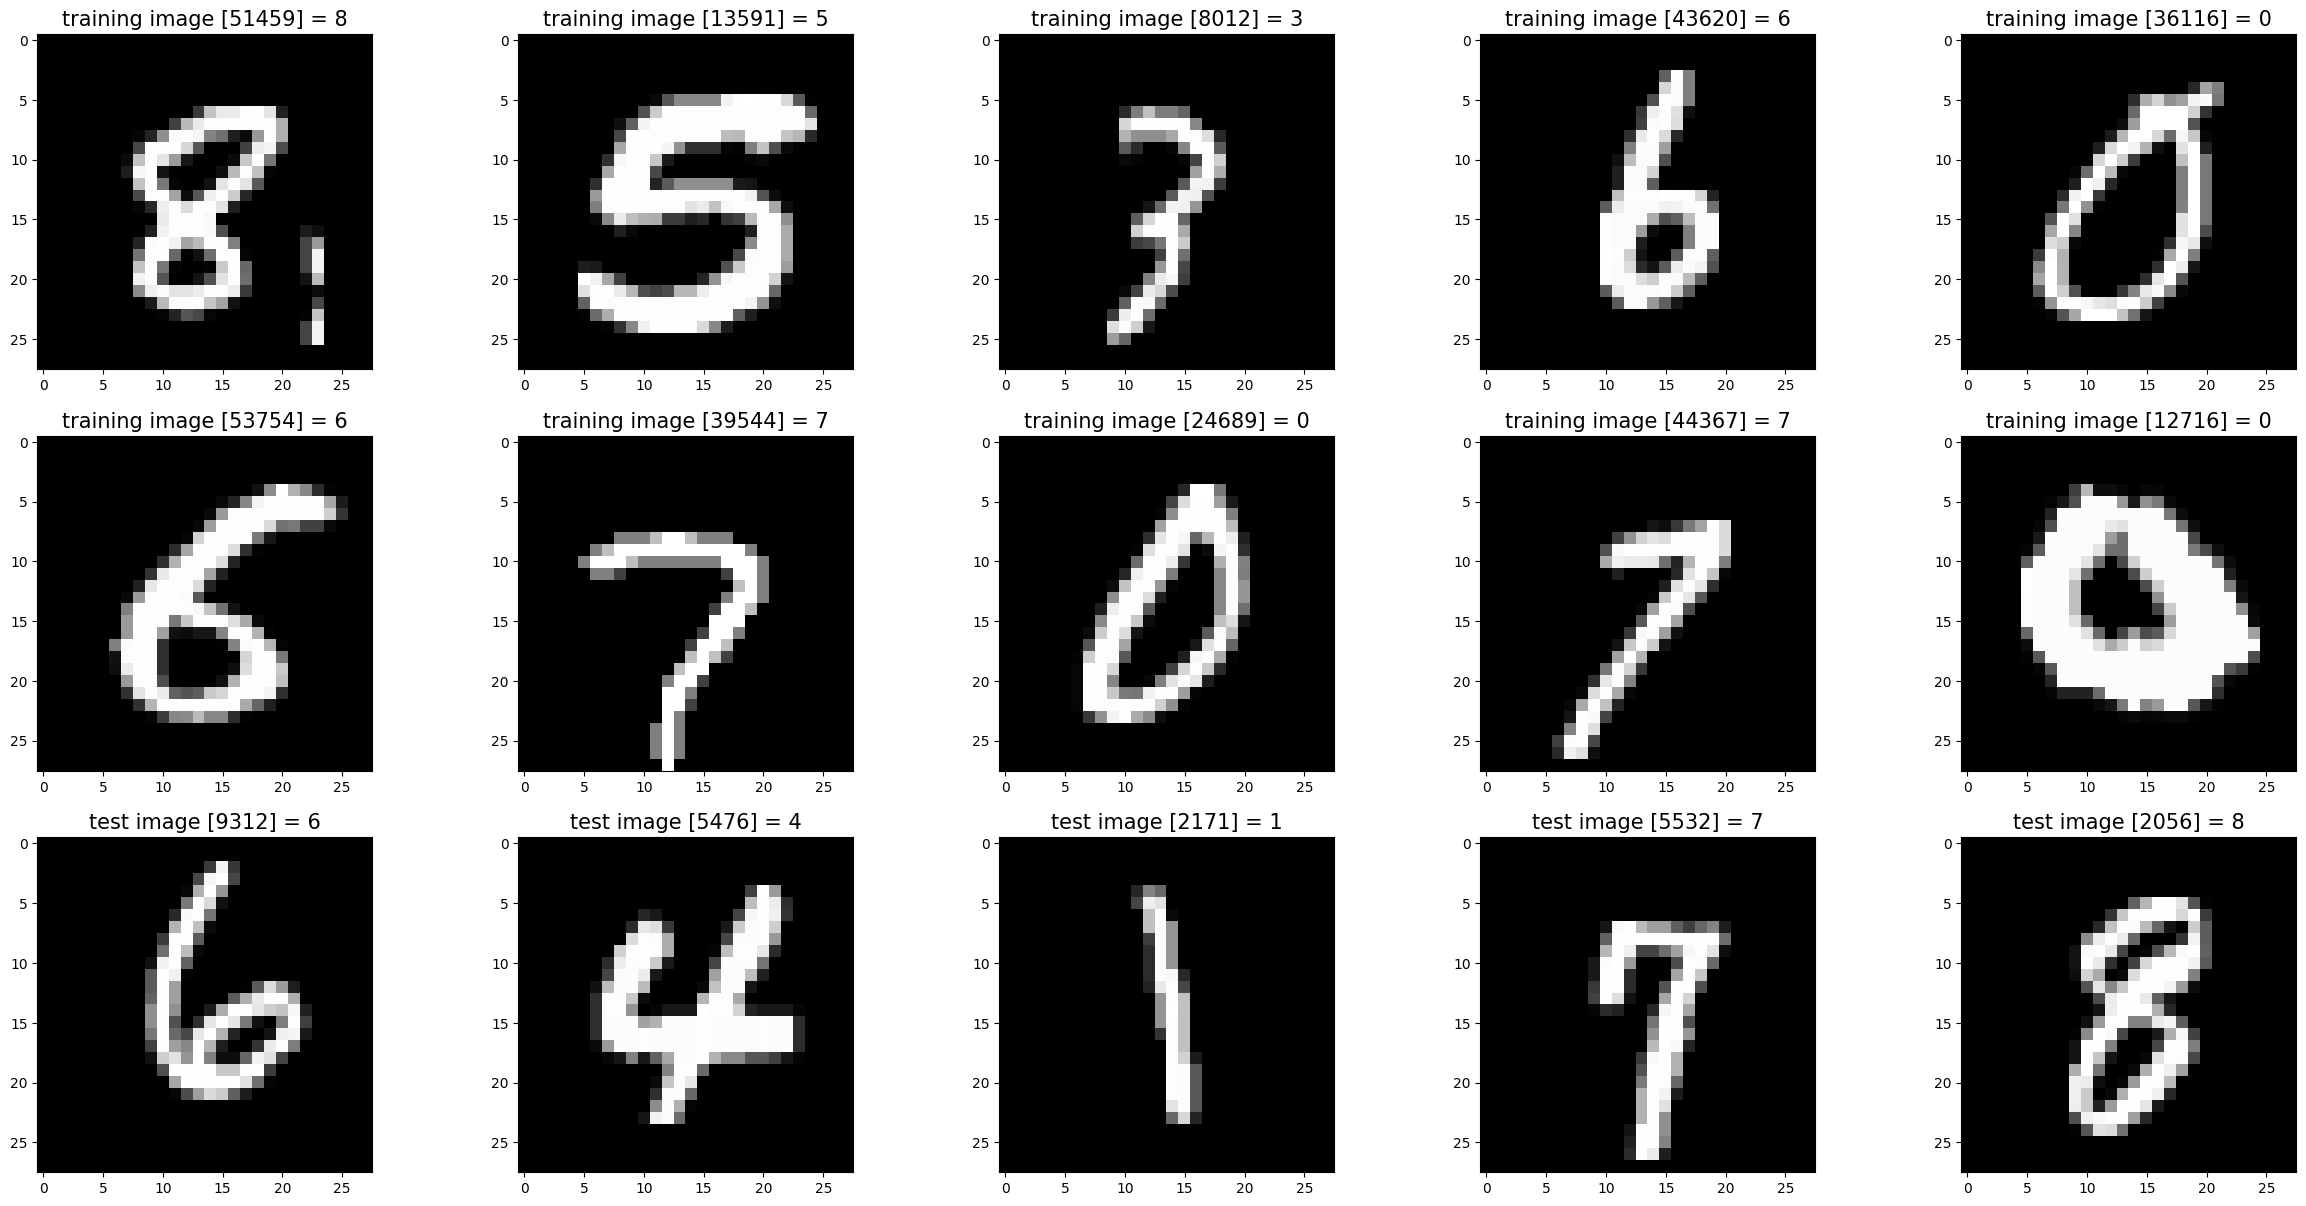

In [2]:
#
# Set file paths based on added MNIST Datasets
#
input_path = 'D:/MNIST'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#

# Helper function modified for CuPy support
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        # Convert CuPy array to NumPy for visualization
        image = x[0].get() if isinstance(x[0], cp.ndarray) else x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15)        
        index += 1

# Load MNIST dataset with CuPy
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, 
                                 test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Convert data to CuPy arrays
x_train = cp.array(x_train)
y_train = cp.array(y_train)
x_test = cp.array(x_test)
y_test = cp.array(y_test)

# Show random images (modified for CuPy)
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r].get()))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r].get()))    

show_images(images_2_show, titles_2_show)

Checking the CuPy array Shapes

In [3]:

# Print original shapes
print('Original training images shape:', cp.array(x_train).shape)
print('Original test images shape:', cp.array(x_test).shape)

# Flatten images
x_train_flat =cp.array(x_train).reshape(len(x_train), -1)
x_test_flat =cp.array(x_test).reshape(len(x_test), -1)

# Print flattened shapes
print('\nFlattened training images shape:', x_train_flat.shape)
print('Flattened test images shape:', x_test_flat.shape)


Original training images shape: (60000, 28, 28)
Original test images shape: (10000, 28, 28)

Flattened training images shape: (60000, 784)
Flattened test images shape: (10000, 784)


# Our Main Model without using Pytorch, Keras etc

In [4]:
class MLP:
    def __init__(self, input_size=784, hidden_size=128, output_size=10, initial_learning_rate=0.01, decay_rate=0.1):
        # Xavier/Glorot initialization
        self.weights_input_hidden = cp.random.randn(input_size, hidden_size) * cp.sqrt(2.0/input_size)
        self.weights_hidden_output = cp.random.randn(hidden_size, output_size) * cp.sqrt(2.0/hidden_size)
        self.bias_hidden = cp.zeros((1, hidden_size))
        self.bias_output = cp.zeros((1, output_size))
        self.initial_learning_rate = initial_learning_rate
        self.decay_rate = decay_rate
        self.losses = []
        self.accuracies = []

    def get_learning_rate(self, epoch):
        """Calculate learning rate with exponential decay"""
        return self.initial_learning_rate * (1 / (1 + self.decay_rate * epoch))

    def relu(self, x):
        return cp.maximum(0, x)
    
    def relu_derivative(self, x):
        return cp.where(x > 0, 1, 0)

    def forward(self, X):
        # Normalize input to [0,1]
        X = X / 255.0
        
        # Forward pass with ReLU activation
        self.hidden_input = cp.dot(X, self.weights_input_hidden) + self.bias_hidden
        self.hidden_output = self.relu(self.hidden_input)
        self.final_input = cp.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
        self.final_output = self.softmax(self.final_input)
        return self.final_output

    def backward(self, X, y, output, learning_rate):
        X = X / 255.0  # Normalize input
        batch_size = X.shape[0]
        y_one_hot = cp.eye(10)[y]
        
        # Output layer error
        output_error = output - y_one_hot
        
        # Hidden layer error (using ReLU derivative)
        hidden_error = cp.dot(output_error, self.weights_hidden_output.T) * \
                      self.relu_derivative(self.hidden_input)
        
        # Gradient descent with momentum
        if not hasattr(self, 'v_who'):
            self.v_who = cp.zeros_like(self.weights_hidden_output)
            self.v_wih = cp.zeros_like(self.weights_input_hidden)
            
        momentum = 0.9
        
        # Output layer updates with momentum
        grad_who = cp.dot(self.hidden_output.T, output_error) / batch_size
        self.v_who = momentum * self.v_who - learning_rate * grad_who
        self.weights_hidden_output += self.v_who
        self.bias_output -= learning_rate * cp.mean(output_error, axis=0, keepdims=True)
        
        # Hidden layer updates with momentum
        grad_wih = cp.dot(X.T, hidden_error) / batch_size
        self.v_wih = momentum * self.v_wih - learning_rate * grad_wih
        self.weights_input_hidden += self.v_wih
        self.bias_hidden -= learning_rate * cp.mean(hidden_error, axis=0, keepdims=True)

    def train(self, X, y, epochs=100, learning_rate=0.01):
        self.initial_learning_rate = learning_rate
        
        for epoch in range(epochs):
            # Get current learning rate
            current_lr = self.get_learning_rate(epoch)
            
            output = self.forward(X)
            self.backward(X, y, output, current_lr)  # Use decayed learning rate
            
            # Calculate metrics
            loss = -cp.mean(cp.log(cp.clip(output[range(len(y)), y], 1e-10, 1.0)))
            accuracy = self.accuracy(X, y)
            
            self.losses.append(loss)
            self.accuracies.append(accuracy)
            
            if (epoch+1) % 10 == 0:
                print(f'Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%, LR: {current_lr:.6f}')
    
    def sigmoid(self, x):
        return 1 / (1 + cp.exp(-x))
    
    def softmax(self, x):
        exp_x = cp.exp(x - cp.max(x))
        return exp_x / exp_x.sum(axis=1, keepdims=True)

    def predict(self, X):
        output = self.forward(X)
        return cp.argmax(output, axis=1)

    def accuracy(self, X, y):
        return cp.mean(self.predict(X) == y) * 100

    def plot_learning_curve(self):
        plt.figure(figsize=(10, 6))
        # Convert CuPy array to NumPy for plotting
        losses = [loss.get() if isinstance(loss, cp.ndarray) else loss for loss in self.losses]
        plt.plot(range(1, len(losses)+1), losses)
        plt.title('Training Loss vs Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.grid(True)
        plt.show()

    def plot_confusion_matrix(self, X_test, y_test):
        # Get predictions
        y_pred = self.predict(X_test)
        
        # Convert CuPy arrays to NumPy for confusion matrix
        y_test_np = y_test.get() if isinstance(y_test, cp.ndarray) else y_test
        y_pred_np = y_pred.get() if isinstance(y_pred, cp.ndarray) else y_pred
        
        # Create confusion matrix
        cm = confusion_matrix(y_test_np, y_pred_np)
        
        # Plot
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

# Training, Testing and Plotting

Epoch 10, Loss: 0.7514, Accuracy: 81.09%, LR: 0.048077
Epoch 20, Loss: 0.4853, Accuracy: 85.66%, LR: 0.030488
Epoch 30, Loss: 0.4262, Accuracy: 87.48%, LR: 0.022321
Epoch 40, Loss: 0.3963, Accuracy: 88.45%, LR: 0.017606
Epoch 50, Loss: 0.3772, Accuracy: 89.04%, LR: 0.014535
Epoch 60, Loss: 0.3643, Accuracy: 89.41%, LR: 0.012376
Epoch 70, Loss: 0.3549, Accuracy: 89.70%, LR: 0.010776
Epoch 80, Loss: 0.3480, Accuracy: 89.90%, LR: 0.009542
Epoch 90, Loss: 0.3425, Accuracy: 90.09%, LR: 0.008562
Epoch 100, Loss: 0.3381, Accuracy: 90.22%, LR: 0.007764
Epoch 110, Loss: 0.3344, Accuracy: 90.31%, LR: 0.007102
Epoch 120, Loss: 0.3313, Accuracy: 90.40%, LR: 0.006545

Prediction distribution:
Digit 0: 1025
Digit 1: 1139
Digit 2: 985
Digit 3: 1029
Digit 4: 1032
Digit 5: 842
Digit 6: 965
Digit 7: 1007
Digit 8: 987
Digit 9: 989


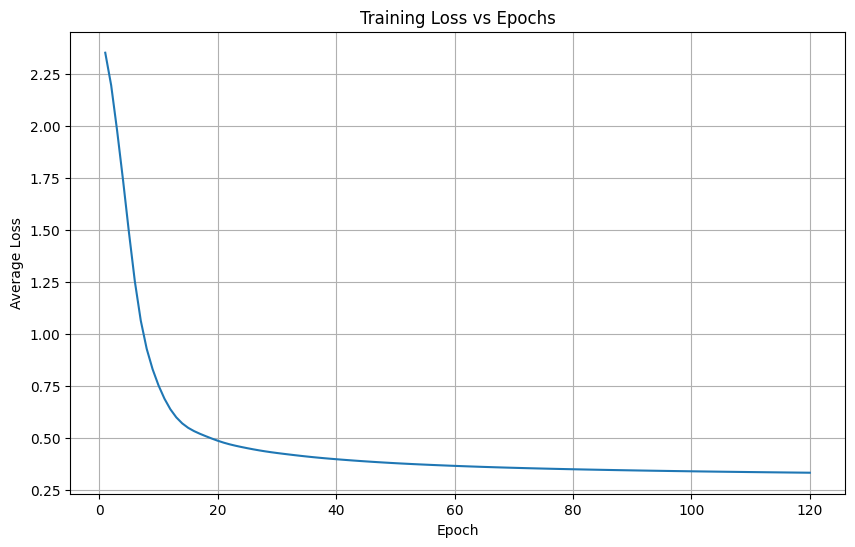

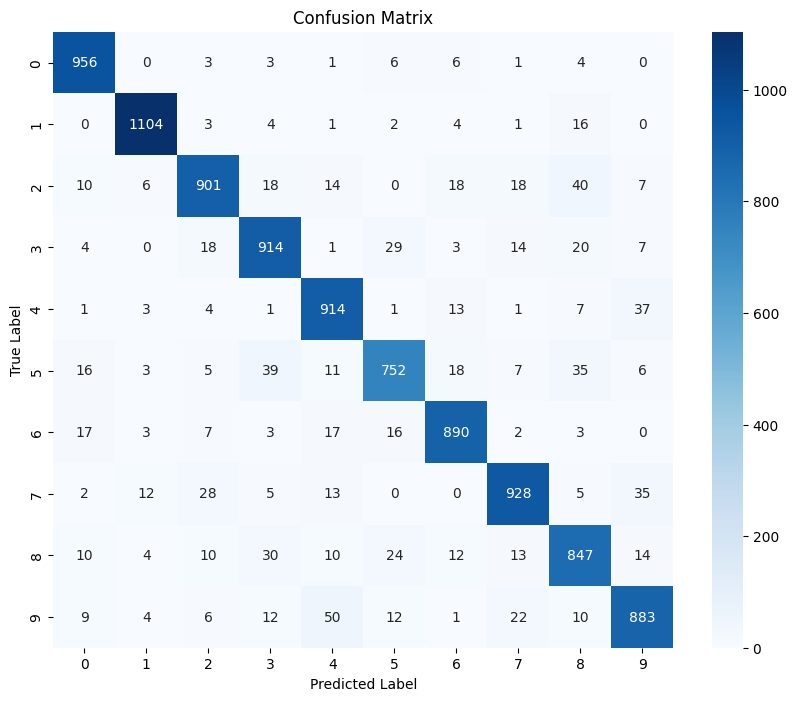

In [10]:
# Create and train the model
mlp = MLP(input_size=784, hidden_size=512, output_size=10, initial_learning_rate=0.1, decay_rate=0.12)  # Increased hidden size
mlp.train(x_train_flat, y_train, epochs=120, learning_rate=0.1)  # Increased learning rate

# Check predictions
y_pred = mlp.predict(x_test_flat)
unique, counts = np.unique(y_pred, return_counts=True)
print("\nPrediction distribution:")
for digit, count in zip(unique, counts):
    print(f"Digit {digit}: {count}")

# Plot learning curve and confusion matrix
mlp.plot_learning_curve()
mlp.plot_confusion_matrix(x_test_flat, y_test)

Generating random image and Predicting it

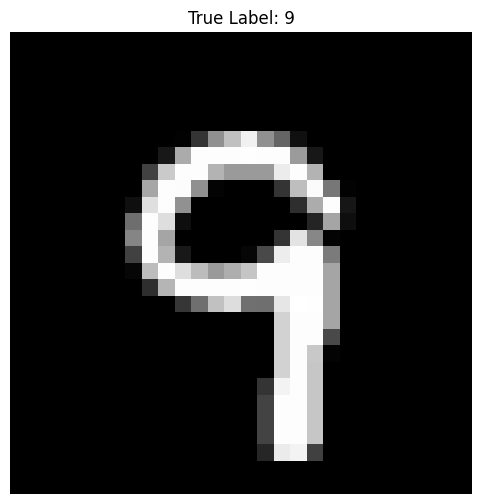

Predicted Label: 9
Confidence: 96.83%

Confidence for each digit:
Digit 0: 0.00%
Digit 1: 0.00%
Digit 2: 0.03%
Digit 3: 0.19%
Digit 4: 2.25%
Digit 5: 0.08%
Digit 6: 0.00%
Digit 7: 0.46%
Digit 8: 0.17%
Digit 9: 96.83%


In [9]:
# Get a random index
random_idx = random.randint(0, len(x_test) - 1)

# Get the image and its true label
test_image = x_test[random_idx]
true_label = y_test[random_idx]

# Show the image
plt.figure(figsize=(6,6))
plt.imshow(test_image.get(), cmap='gray')  # Convert to NumPy array for plotting
plt.title(f'True Label: {true_label.get()}')
plt.axis('off')
plt.show()

# Get model prediction and confidence
test_image_flat = test_image.reshape(1, -1)
output = mlp.forward(test_image_flat)
predicted_label = cp.argmax(output)
confidence = output[0, predicted_label] * 100

print(f'Predicted Label: {predicted_label.get()}')
print(f'Confidence: {confidence.get():.2f}%')

# Show confidence for all digits
print('\nConfidence for each digit:')
for digit in range(10):
    print(f'Digit {digit}: {output[0,digit].get()*100:.2f}%')